Yellowbrick可视化工具旨在指导模型选择过程。一般来说，模型选择是一个搜索问题，定义如下：给定N个由数值属性描述的实例和（可选）一个估计目标，找到一个由特征、算法和最适合数据的超参数组成的三元组描述的模型。在大多数情况下，“最佳”三元组是指收到模型类型的最佳交叉验证分数的三元组。

Yellowbrick.model_select包提供了可视化工具，用于检查交叉验证和超参数调优的性能。
许多可视化工具包装sklearn.model_select和其他工具中的功能，用于执行多模型比较。

当前实现的模型选择可视化器如下：
+ 验证曲线：可视化超参数的调整如何影响训练和测试分数，以调整偏差/方差。
+ 学习曲线：显示训练数据的大小如何影响模型，以诊断模型是否受方差误差和偏差误差的影响更大。
+ 交叉验证分数：将交叉验证的分数显示为条形图，平均值作为水平线。
+ 特征重要性：按模型中的相对重要性对特征进行排名
+ 递归特征消除：按重要性选择特征子集

模型选择大量使用交叉验证来评估估计器的性能。交叉验证将数据集分为训练数据集和测试数据集；该模型适合训练数据，并根据测试数据进行评估。这有助于避免常见的陷阱，过度拟合，因为模型只会记住训练数据，而不能很好地推广到新的或未知的输入中。

有很多方法可以定义如何拆分数据集以进行交叉验证。有关scikit-learn如何实现这些机制的更多信息，请查阅scikit-learn文档中的[交叉验证：评估估计器性能。](http://scikit-learn.org/stable/modules/cross_validation.html)

本文如果数据集下载不下来，查看下面地址，然后放入yellowbrick安装目录\datasets\fixtures文件夹:



```
{
  "bikeshare": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/bikeshare.zip",
    "signature": "4ed07a929ccbe0171309129e6adda1c4390190385dd6001ba9eecc795a21eef2"
  },
  "hobbies": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/hobbies.zip",
    "signature": "6114e32f46baddf049a18fb05bad3efa98f4e6a0fe87066c94071541cb1e906f"
  },
  "concrete": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/concrete.zip",
    "signature": "5807af2f04e14e407f61e66a4f3daf910361a99bb5052809096b47d3cccdfc0a"
  },
  "credit": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/credit.zip",
    "signature": "2c6f5821c4039d70e901cc079d1404f6f49c3d6815871231c40348a69ae26573"
  },
  "energy": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/energy.zip",
    "signature": "174eca3cd81e888fc416c006de77dbe5f89d643b20319902a0362e2f1972a34e"
  },
  "game": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/game.zip",
    "signature": "ce799d1c55fcf1985a02def4d85672ac86c022f8f7afefbe42b20364fba47d7a"
  },
  "mushroom": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/mushroom.zip",
    "signature": "f79fdbc33b012dabd06a8f3cb3007d244b6aab22d41358b9aeda74417c91f300"
  },
  "occupancy": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/occupancy.zip",
    "signature": "0b390387584586a05f45c7da610fdaaf8922c5954834f323ae349137394e6253"
  },
  "spam": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/spam.zip",
    "signature": "000309ac2b61090a3001de3e262a5f5319708bb42791c62d15a08a2f9f7cb30a"
  },
  "walking": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/walking.zip",
    "signature": "7a36615978bc3bb74a2e9d5de216815621bd37f6a42c65d3fc28b242b4d6e040"
  },
  "nfl": {
    "url": "https://s3.amazonaws.com/ddl-data-lake/yellowbrick/v1.0/nfl.zip",
    "signature": "4989c66818ea18217ee0fe3a59932b963bd65869928c14075a5c50366cb81e1f"
  }
}
```


In [1]:
import warnings
warnings.filterwarnings("ignore")

# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1 验证曲线
模型验证用于确定估计器对经过训练的数据的有效性以及对新输入的通用性。为了衡量模型的性能，我们首先将数据集分为训练和测试分割，将模型拟合到训练数据上并在保留的测试数据上评分。

为了使评分最大化，必须选择模型的超参数，使模型在指定的特征空间内运行。大多数模型都有多个超参数，选择这些参数组合的最佳方法是使用网格搜索。然而，有时绘制单个超参数对训练和测试数据的影响，以确定估计器对某些超参数值是欠拟合还是过拟合是有用的。


|可视化器|ValidationCurve|
|-|-|
|快速使用方法|validation_curve()|
|模型|分类与回归|
|工作流程|选型|

## 1.1 基础使用
在第一个示例中，我们将使用ValidationCurve可视化工具探索回归数据集，在第二个示例中探索分类数据集。请注意，任何实现fit()且predict()具有适当评分机制的估算器均可与此可视化工具一起使用。

In [2]:
import numpy as np

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import ValidationCurve

from sklearn.tree import DecisionTreeRegressor

# Load a regression dataset
X, y = load_energy()

# param_name参数名称
# param_range参数范围
# cv交叉认证指定折数
# scoring评价指标
viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show();

<Figure size 800x550 with 1 Axes>

在加载和修改数据之后，我们使用一个DecisionTreeRegressor初始化ValidationCurve。决策树越深越过适合，因为在树的每一层，分区处理的数据子集越小。处理这种过拟合过程的一种方法是限制树的深度。验证曲线探索了“max_depth”参数与R2评分之间的关系，并进行了10个shuffle拆分交叉验证。参数param_range指定max_depth的值，这里从1到10不等。

从可视化结果中我们可以看到，深度限制小于5个水平严重不适合这个数据集上的模型，因为训练分数和测试分数在这个参数范围内一起攀升，并且由于测试分数交叉验证的高可变性。深度为7之后，训练和测试的分数就会出现分歧，这是因为更深的树开始过度拟合训练数据，无法为模型提供普遍性。然而，由于交叉验证的分数不一定会减少，所以模型不会因为方差而产生很大的误差。


## 1.2 快速方法
使用关联的快速方法，可以在一行中实现与上述类似的功能validation_curve。此方法将实例化并适合ValidationCurve可视化器。

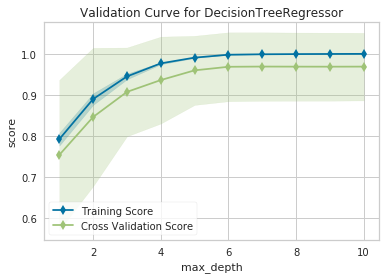

In [3]:
import numpy as np

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import validation_curve

from sklearn.tree import DecisionTreeRegressor

# Load a regression dataset
X, y = load_energy()

viz = validation_curve(
    DecisionTreeRegressor(), X, y, param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2",
)

# 2 学习曲线
学习曲线显示了针对具有不同数量训练样本的估计量，训练分数与交叉验证的测试分数之间的关系。该可视化通常用于显示两件事：

估算器可从更多数据中受益多少（例如，我们是否有“足够的数据”，或者如果以在线方式使用，估算器会变得更好）。

如果估算器对因方差引起的误差与因偏差引起的误差更敏感。



|可视化器|LearningCurve|
|-|-|
|快速使用方法|learning_curve()|
|模型|分类，回归，聚类|
|工作流程|选型|

如果训练和交叉验证的分数随着更多数据的增加而聚合在一起（如左图所示），那么模型可能不会从更多的数据中获益。如果训练得分远大于验证得分，那么模型可能需要更多的训练实例，以便更有效地推广。
曲线用平均得分绘制，但是交叉验证过程中的可变性用阴影区域表示，所有交叉验证的平均值上下都有一个标准偏差。如果模型由于偏差而出现误差，那么在训练分数曲线附近可能会有更多的变化。如果模型由于方差而出现误差，那么在交叉验证得分附近会有更多的可变性。

## 2.1 分类
在下面的示例中，我们将展示如何可视化分类模型的学习曲线。
在加载DataFrame并执行分类编码之后，我们创建了一个StratifiedKFold交叉验证策略，以确保每个拆分中的所有类都以相同的比例表示。
然后，我们使用F1_加权评分度量(而不是默认度量准确度)来拟合可视化工具，以更好地了解分类器中的精确度和召回率之间的关系。

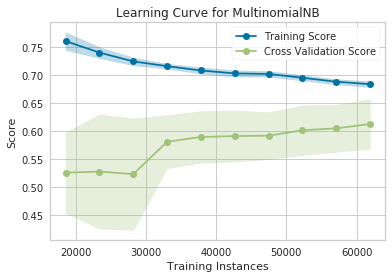

In [4]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Load a classification dataset
X, y = load_game()

# Encode the categorical data
X = OneHotEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show();      

这条学习曲线显示了高测试可变性和低分数，高达30000个实例，然而在这个水平之后，模型开始收敛到F1分数0.6左右。我们可以看到训练和测试的分数还没有收敛，所以这个模型可能会从更多的训练数据中获益。最后，该模型主要受方差误差的影响（测试数据的CV分数比训练数据的变异性更大），因此模型有可能过度拟合。

## 2.2 回归
为回归建立学习曲线非常简单，而且非常相似。在下面的示例中，在加载数据并选择目标之后，我们根据确定系数或R2分数探索学习曲线分数。

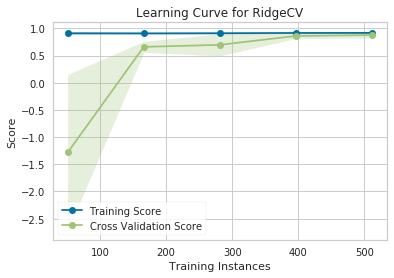

In [5]:
from sklearn.linear_model import RidgeCV

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import LearningCurve

# Load a regression dataset
X, y = load_energy()

# Instantiate the regression model and visualizer
model = RidgeCV()
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

该学习曲线显示出非常高的可变性，并且得分较低，直到大约350个实例为止。显然，该模型可以从更多数据中受益，因为它的得分很高。潜在地，随着更多的数据和更大的正则化alpha值，该模型在测试数据中的可变性将大大降低

## 2.3 聚类
学习曲线也适用于聚类模型，并且可以使用指定聚类的形状或组织的度量，例如轮廓分数或密度分数。如果预先知道membership，则可以使用rand得分来比较聚类性能，如下所示：

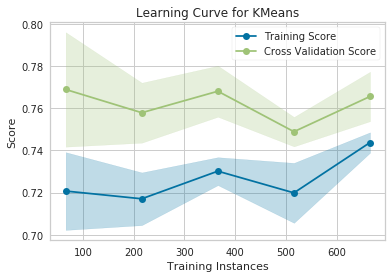

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.model_selection import LearningCurve

# Generate synthetic dataset with 5 random clusters
X, y = make_blobs(n_samples=1000, centers=5, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = LearningCurve(model, scoring="adjusted_rand_score", random_state=42)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

不幸的是，对于随机数据，这些曲线变化很大，但是可以指出一些特定于聚类的项。首先，请注意y轴很窄，粗略地说，这些曲线是收敛的，并且实际上聚类算法的表现非常好。其次，对于集群而言，数据点的收敛不一定是一件坏事；实际上，我们希望确保在添加更多数据时，训练和交叉验证分数不会出现差异。

## 2.4 快速方法
使用关联的快速方法可以实现相同的功能learning_curve。此方法将LearningCurve使用关联的参数构建对象，将其拟合，然后（可选）立即显示可视化效果。

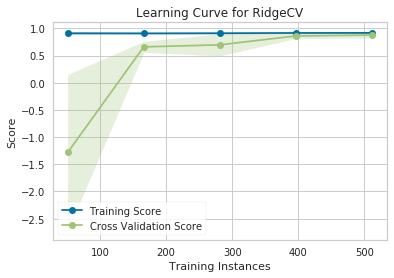

In [7]:
from sklearn.linear_model import RidgeCV

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import learning_curve

# Load a regression dataset
X, y = load_energy()

learning_curve(RidgeCV(), X, y, scoring='r2');

# 3 交叉验证分数
通常，我们通过查看给定模型的F1，精度，召回率和准确性（用于分类），或者确定系数（R2）和误差（用于回归）来确定其是否最优。但是，现实世界中的数据通常分布不均，这意味着拟合模型在数据的某些部分上的表现可能要好于其他部分。Yellowbrick的CVScores可视化工具使我们能够使用不同的交叉验证策略直观地探索这些性能差异。


|可视化器|CVScores|
|-|-|
|快速使用方法|cv_scores()|
|模型|分类，回归|
|工作流程|选型|

## 3.1 交叉验证介绍
交叉验证首先对数据进行无序处理（以防止意外的排序错误）并将其拆分为k个折叠。然后k模型适用于k-1/k的数据（称为训练分割），并对1/k的数据进行评估（称为测试分割）。每个评估的结果被平均在一起作为最终得分，然后最终模型适合于整个数据集进行操作。

在Yellowbrick中，CVScores可视化工具将交叉验证的分数显示为条形图（每折一个条形），所有折的平均分数绘制为水平虚线。

![](https://www.scikit-yb.org/en/latest/_images/cross_validation.png)


## 3.2 分类
在下面的示例中，我们显示了如何可视化分类模型的交叉验证得分。将占用数据加载为之后DataFrame，我们创建了StratifiedKFold交叉验证策略，以确保每个分组中的所有类均以相同的比例表示。然后，我们CVScores使用f1_weighted评分指标而不是默认指标“准确度”来拟合展示台，以便更好地了解分类器中所有折的精确度和召回率之间的关系。

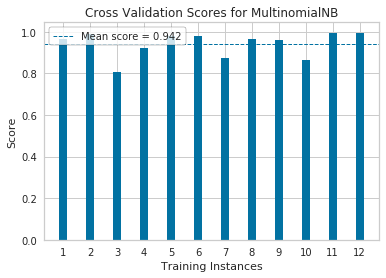

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import CVScores

# Load the classification dataset
X, y = load_occupancy()

# Create a cross-validation strategy
# 浇查验证策略
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = MultinomialNB()
# 交叉验证获得分数
visualizer = CVScores(model, cv=cv, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

我们得到的可视化结果表明，尽管我们的平均交叉验证得分非常高，但是在某些拆分中，我们的拟合MultinomialNB分类器的效果明显较差。

## 3.3 回归
在下一个示例中，我们显示如何可视化回归模型的交叉验证得分。在以加载enerygy数据，我们实例化了一个简单的KFold交叉验证策略。然后，我们通过CVScores使用r2计分指标对展示台进行拟合，以了解所有折处回归器的确定系数。

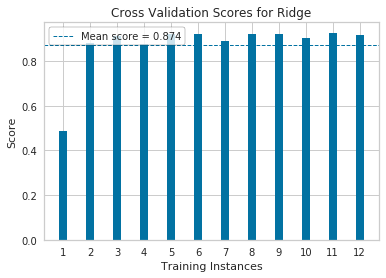

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import CVScores

# Load the regression dataset
X, y = load_energy()

# Instantiate the regression model and visualizer
cv = KFold(n_splits=12, random_state=42)

model = Ridge()
visualizer = CVScores(model, cv=cv, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show();         # Finalize and render the figure

与我们的分类CVScores可视化一样，我们的回归可视化表明我们的Ridge回归器几乎在所有折中都表现非常出色（例如，产生较高的确定系数），从而导致总体R2得分更高。



## 3.4 快速方法
上面的相同功能可以通过关联的快速方法来实现cv_scores。此方法将CVScores使用关联的参数构建对象，将其拟合，然后（可选）立即显示可视化效果。

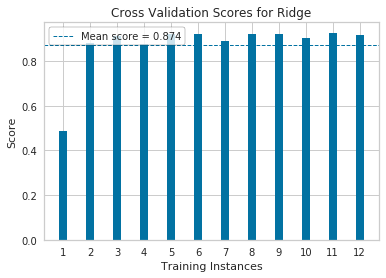

In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import cv_scores

# Load the regression dataset
X, y = load_energy()

# Instantiate the regression model and visualizer
cv = KFold(n_splits=12, random_state=42)

model = Ridge()
visualizer = cv_scores(model, X, y, cv=cv, scoring='r2');

# 4 特征重要性
特征工程过程包括选择所需的最小特征来生成一个有效的模型，因为模型包含的特征越多，它就越复杂（数据越稀疏），因此模型对方差引起的误差就越敏感。消除特征的一种常见方法是描述它们对模型的相对重要性，然后消除薄弱的特征或特征的组合，然后重新评估，以确定在交叉验证期间模型是否更好。

许多模型形式描述了要素相对于彼此的潜在影响。在scikit-learn中，决策树模型和树的集合（例如，Random Forest，Gradient Boosting和Ada Boost）会feature_importances_在拟合时提供 属性。Yellowbrick FeatureImportances可视化工具利用此属性对相对重要性进行排名和绘图。

|可视化器|FeatureImportances|
|-|-|
|快速使用方法|feature_importances()|
|模型|分类，回归|
|工作流程|选型,特征提取|


## 4.1 基本使用
让我们从一个例子开始；首先加载分类数据集。

然后，我们可以创建一个新图形（这是可选的，如果Axes未指定，Yellowbrick将使用当前图形或创建一个图形）。然后，我们可以为FeatureImportances展示台添加，GradientBoostingClassifier以可视化排名特征。

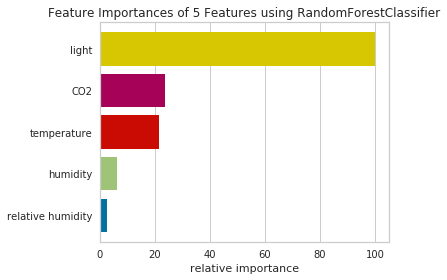

In [11]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set
X, y = load_occupancy()

model = RandomForestClassifier(n_estimators=10)
# 显示特征对于分类的重要程度
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show();

相对于其相对重要性（即最重要特征的重要性百分比）绘制特征。可视化器还包含features_和 feature_importances_属性以获取排名的数值。

对于不支持feature_importances_属性的 模型，FeatureImportances可视化工具还将为coef_ 许多线性模型提供的属性绘制条形图。但是要注意的是系数重要性的解释取决于模型。

使用带有coef_属性的模型时，最好设置 relative=False为绘制系数的真实大小（可能为负）。如果数据集没有列名或打印更好的标题，我们也可以指定我们自己的标签集。在下面的示例中，我们为案例加了标题以提高可读性：

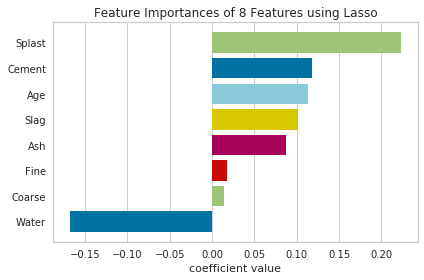

In [12]:
from sklearn.linear_model import Lasso
from yellowbrick.datasets import load_concrete
from yellowbrick.model_selection import FeatureImportances

# Load the regression dataset
dataset = load_concrete(return_dataset=True)
X, y = dataset.to_data()

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), dataset.meta['features']))
viz = FeatureImportances(Lasso(), labels=labels, relative=False)

# Fit and show the feature importances
viz.fit(X, y)
viz.show();

## 4.2 堆叠重要性特征
有些估计器返回一个多维数组，用于feature_importances_x或coef_u属性。例如，在多类情况下，LogisticRegression分类器返回一个coef_u数组，其形状为（n_classes，n_features）。这些系数将特征的重要性映射到特定类别的概率预测中。虽然多维特征重要性的解释依赖于特定的估计器和模型族，但是在FeatureImportances visualizer中对数据的处理是相同的，即重要性被平均化。

出于几个原因，采用重要性的平均值可能是不可取的。例如，某个特性对于某些类来说可能比其他类更具信息量。在本质上是多个内部模型的情况下，多输出估计量也不会从中受益。在这种情况下，使用stack=True参数绘制重要程度的堆积条形图，如下所示：

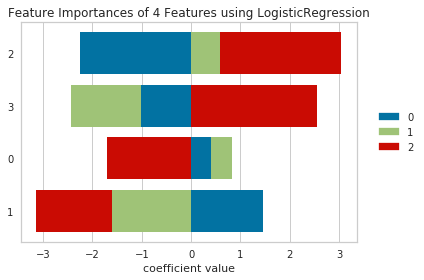

In [13]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

data = load_iris()
X, y = data.data, data.target

model = LogisticRegression(multi_class="auto", solver="liblinear")
viz = FeatureImportances(model, stack=True, relative=False)
viz.fit(X, y)
viz.show();

## 4.3 快速方法
可以通过关联的快速方法feature_importances实现上述相同功能。此方法将FeatureImportances使用关联的参数构建对象，将其拟合，然后
from sklearn.ensemble import AdaBoostClassifier（可选）立即显示它。

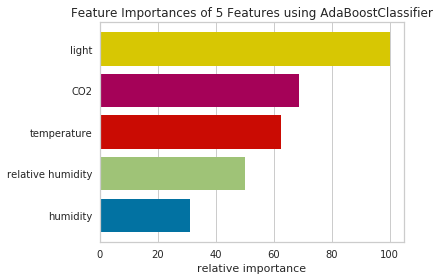

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import feature_importances

# Load dataset
X, y = load_occupancy()

# Use the quick method and immediately show the figure
feature_importances(AdaBoostClassifier(), X, y);

# 5 递归特征消除
递归特征消除（RFE）是一种特征选择方法，它适合模型并删除最弱的一个或多个特征，直到达到指定数量的特征为止。特征按模型coef_或feature_importances_属性进行排序，并且通过递归消除每个循环中的少量特征，RFE尝试消除模型中可能存在的依赖关系和共线性。

RFE需要保留指定数量的功能，但是通常事先不知道有多少有效功能。为了找到最佳数量的特征，将交叉验证与RFE一起使用，对不同的特征子集进行评分，并选择最佳的特征评分集合。该RFECV可视化工具绘制的模型特征的数量与他们的交叉验证测试分数和多变性和可视化选择的多项功能一起。

为了展示其在实际中的工作方式，我们将从一个人为设计的示例开始，该示例使用的数据集中只有25个中的3个信息功能。

|可视化器|RFECV|
|-|-|
|快速使用方法|rfecv()|
|模型|分类，回归|
|工作流程|选型|

## 5.1 基础使用

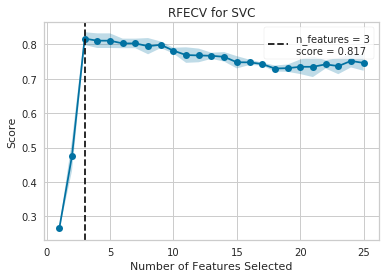

In [15]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification

from yellowbrick.model_selection import RFECV

# Create a dataset with only 3 informative features
# 只有三个有效特征
X, y = make_classification(
    n_samples=1000, n_features=25, n_informative=3, n_redundant=2,
    n_repeated=0, n_classes=8, n_clusters_per_class=1, random_state=0
)

# Instantiate RFECV visualizer with a linear SVM classifier
visualizer = RFECV(SVC(kernel='linear', C=1))

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

该图显示了一条理想的RFECV曲线，当捕获了三个信息性特征时，该曲线跳至极佳的精度，然后随着将非信息性特征添加到模型中而逐渐降低了精度。阴影区域表示交叉验证的变异性，即曲线绘制的平均准确度得分之上和之下的一个标准偏差。

探索真实数据集，我们可以看到RFECV对credit默认二进制分类器的影响。

RFECV(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f04351ba190>,
   cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
   groups=None, model=None, scoring='f1_weighted', step=1)

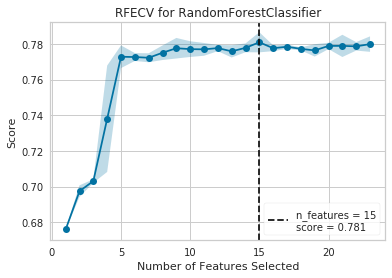

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import RFECV
from yellowbrick.datasets import load_credit

# Load classification dataset
X, y = load_credit()

cv = StratifiedKFold(2)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

在此示例中，我们可以看到选择了15个特征，尽管在大约5个特征之后，模型的f1得分似乎没有太大改善。选择要消除的特征在确定每次递归的结果中起着很大的作用；修改step参数以在每个步骤中消除一个以上的特征可能有助于尽早消除最差的特征，从而增强其余特征（并且还可以用于加快具有大量特征的数据集的特征消除）。

## 5.2 快速方法
上面的相同功能可以通过关联的快速方法来实现rfecv。此方法将RFECV使用关联的参数构建对象，将其拟合，然后（可选）立即显示可视化效果。

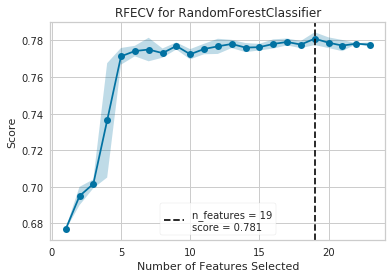

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import rfecv
from yellowbrick.datasets import load_credit

# Load classification dataset
X, y = load_credit()

cv = StratifiedKFold(2)
visualizer = rfecv(RandomForestClassifier(), X=X, y=y, cv=cv, scoring='f1_weighted');

# 6 参考
[https://www.scikit-yb.org/en/latest/api/model_selection/validation_curve.html](https://www.scikit-yb.org/en/latest/api/model_selection/validation_curve.html)

[https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html](https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html)

[https://www.scikit-yb.org/en/latest/api/model_selection/cross_validation.html](https://www.scikit-yb.org/en/latest/api/model_selection/cross_validation.html)

[https://www.scikit-yb.org/en/latest/api/model_selection/importances.html](https://www.scikit-yb.org/en/latest/api/model_selection/importances.html)

[https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html](https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html)